### Theory

#### Hypothesis Testing – The problem of multiple comparisons [5 points]

##### Question A
On the first experiment ($m = 1$) the chance that the results are significant given that the experiment lacks the power to reject is equal to $\alpha$. On the second experiment it is equal to $\alpha * P(\text{We didn't reject experiment } m-1)$. So

$$P(m^{th} \text{ experiment is significant | } m \text{ experiments lacking power to reject } H_0) = (1 - \alpha)^{m-1} * \alpha$$

Example:

$\alpha = 0.05$

$m = 6$

$P(6^{th} \text{ experiment is significant | } 6 \text{ experiments lacking power to reject } H_0) = (1-0.05)^{6-1}*0.05 \approx 0.038$

#### Question B

There is an increased chance of finding at least one false significant finding the more tests you perform. If m independent comparisons are performed, the family wise error rate (FWER) can be used. The formula for the FWER is the following:

$$\alpha_{fw} = 1-(1-\alpha)^{m}$$

so

$$P(\text{ at least one significant result | } m \text{ experiments lacking power to reject } H_0) = \alpha_{fw}$$

To arrive at this result, observe that this is $1 - P(m \text{ insignificant results | } m \text{ experiments lacking power to reject } H_0)$

Example:

$\alpha = 0.05$

$m = 6$

$\alpha_{fw} = 1-(1-0.05)^6\approx0.26$

#### Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?

Ranking P

| D1 N |<br>
| D2 N |<br>
| D3 R |<br>

Ranking E

| D2 N |<br>
| D3 R |<br>
| D1 N |<br>

Because D3 is the only relevant document, we'd expect it's clicks to be attributed to E more often than to P.

The set of possible interleaved rankings using Team-Draft Interleaving is as follows:

| D1 N (P) | &emsp; | D1 N (P) | &emsp; | D2 N (E) | &emsp; | D2 N (E) | <br>
| D2 N (E) | &emsp; | D2 N (E) | &emsp; | D1 N (P) | &emsp; | D1 N (P) | <br>
| D3 R (P) | &emsp; | D3 R (E) | &emsp; | D3 R (P) | &emsp; | D3 R (E) | <br>

Where D3 is in the same position in all rankings, with equal assignments to P and E. Thus, in this case, the expected number of clicks is the same for both ranking functions even though ranking E should win. This is an example of insensitivy to the quality of rankings.

Example is based on: Hofmann, K., Whiteson, S., & De Rijke, M. (2011, October). A probabilistic method for inferring preferences from clicks. In Proceedings of the 20th ACM international conference on Information and knowledge management (pp. 249-258). ACM.

In [2]:
import itertools
import numpy as np

# Added the numbers to facilitate easy sorting.
REL_SCORES = {'N' : 0, 'R' : 1, 'HR' : 2}

# Generate all possible rankings for both Production and Experimental systems
P = list(itertools.product(REL_SCORES.keys(), repeat = 5))
E = list(itertools.product(REL_SCORES.keys(), repeat = 5))
 
rankings = list(itertools.product(P, E))

# Make sure the right amount of combinations are made
assert len(rankings) == 3**10

# Show a sample of the generated rankings
for p, e in rankings[0::10000]:
    print(p)
    print(e)
    print()

('R', 'R', 'R', 'R', 'R')
('R', 'R', 'R', 'R', 'R')

('R', 'HR', 'HR', 'HR', 'N')
('R', 'HR', 'HR', 'R', 'HR')

('HR', 'R', 'R', 'R', 'HR')
('R', 'N', 'N', 'R', 'N')

('HR', 'HR', 'HR', 'N', 'R')
('HR', 'HR', 'R', 'HR', 'R')

('N', 'R', 'R', 'R', 'N')
('HR', 'N', 'HR', 'HR', 'HR')

('N', 'HR', 'HR', 'N', 'HR')
('N', 'R', 'N', 'HR', 'N')



In [3]:
# quote from slide 15: "usually user only looks at very few top results : e.g. precision@3"
def precision_at_k(ranking, k):
    subset = ranking[:k]
    n_relevant = 0
    
    for result in subset:
        if REL_SCORES[result] > 0:
            n_relevant += 1
    
    return n_relevant / k

def DCG_at_k(ranking, k, optimal=False):
    subset = ranking[:k]
    
    if optimal:
        subset = sorted(subset, reverse=True, key=lambda x: REL_SCORES[x])
        
    discounted_score = 0
    
    for i, result in enumerate(subset):
        # prepare variables for DCG formula
        rank = i + 1
        rel = REL_SCORES[result]
        
        # Calculate score
        score = (2**rel - 1) / np.log2(1 + rank)
        discounted_score += score
    
    # NB: sum is part of the formula
    return discounted_score
        
def nDCG_at_k(ranking, k):
    true = DCG_at_k(ranking, k)
    best = DCG_at_k(ranking, k, optimal=True)
    
    # This is to prevent dividing by 0. If the best possible DCG is 0, the
    # true DCG is also zero (because there are no relevant document is the top k)
    if best == 0.0: 
        return 0.0
    else:
        return true / best

def prob_of_relevance(grade, max_grade):
    return (2**grade - 1) / 2**max_grade

def ERR(ranking):
    """Algorithm to compute ERR in linear time, implemented based on 
    
    Chapelle, O., Metlzer, D., Zhang, Y., & Grinspan, P. (2009, November). 
    Expected reciprocal rank for graded relevance. In Proceedings of the 18th ACM conference
    on Information and knowledge management (pp. 621-630). ACM."""
    
    grades = [REL_SCORES[x] for x in ranking]
    max_grade = max(REL_SCORES.values())
    
    p = 1
    err = 0
    
    for r in range(len(grades)):
        R = prob_of_relevance(grades[r], max_grade)
        err += p * (R/(r+1))
        p *= (1 - R)
    
    return err

In [4]:
## This cell does te calculations for all three metrics and saves the results to a list    

depth = 3

precision_p = []
precision_e = []
dcg_p = []
dcg_e = []
err_p = []
err_e = []

for i, (p, e) in enumerate(list(rankings)):
    precision_p.append(precision_at_k(p, depth))
    precision_e.append(precision_at_k(e, depth))

    dcg_p.append(nDCG_at_k(p, depth))
    dcg_e.append(nDCG_at_k(e, depth))
    
    err_p.append(ERR(p))
    err_e.append(ERR(e))

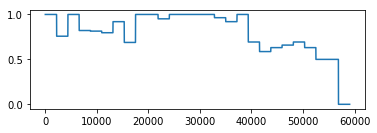

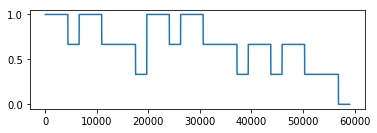

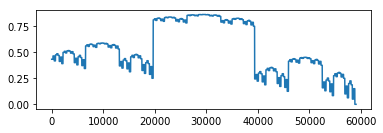

In [5]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(range(len(dcg_p)), dcg_p)

# plt.subplot(212)
# plt.plot(range(len(dcg_e)), dcg_e, linewidth=0.1)

plt.figure(2)
plt.subplot(211)
plt.plot(range(len(precision_p)), precision_p)

# plt.subplot(212)
# plt.plot(range(len(precision_e)), precision_e, linewidth=0.1)

fig = plt.figure(3)
plt.subplot(211)
plt.plot(range(len(err_p)), err_p)

# plt.subplot(212)
# plt.plot(range(len(err_e)), err_e, linewidth=0.1)

plt.show()


#TODO: asxislabels, graphtitles
#TODO: Analsyse algemener maken. De volgorde van R / N / HR is anders op elke machine

### Analysis

The lists in the `rankings` variable represents a simulation of all possible outcomes of a comparisson of model P and model E on a query. Because of the way the combinations are generated, subsequent instances of the E model vary rapidly and thus produce chaotic graphs. So for the graphical analysis, we will focus on model P.

The first thing that stands out is that there is no obvious pattern in the progression of the metrics as you iterate trough the instances. We would've expected a more symmectric shape of the plot. But at further inspection, there is indeed a pattern. This is especially viable when you compare the three metrics with eachoter. All metrics are mininum around the 30.000th pair, which where the rankings are mostly non-relevant. At the beginning and end of the simulations the rankings are made up of mostly 'R' and 'HR' documents so they score high. In the EGG chart you get a more detailed view, since the grade of the rank is taken into account and grade('R') < grade('HR').

In [6]:
def delta_measure(scores_a, scores_b):
    result = []
    for a, b in zip(scores_a, scores_b):
        diff = b - a
        if diff > 0:
            result.append(diff)
    
    return result

# Calculate delta measure for the three chosen metrics
delta_precision = delta_measure(precision_p, precision_e)
delta_nDCG = delta_measure(dcg_p, dcg_e)
delta_ERR = delta_measure(err_p, err_e)

print("Delta precision")
print()
print(delta_precision[0::1000])
print()
print("Percentage of wins for E:", len(delta_precision)/len(rankings))
print()
print()
print("Delta nDCG")
print()
print(delta_nDCG[0::1000])
print()
print("Percentage of wins for E:", len(delta_nDCG)/len(rankings))
print()
print()
print("Delta ERR")
print()
print(delta_ERR[0::1000])
print()
print("Percentage of wins for E:", len(delta_ERR)/len(rankings))

Delta precision

[0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.3333333333333333, 0.3333333333333333, 0.33333333333333337, 0.33333333333333337, 0.6666666666666667, 0.6666666666666667, 0.33333333333333337, 0.6666666666666667, 0.3333333333333333, 0.33333333333333337, 0.6666666666666667, 0.6666666666666667, 0.3333333333333333, 0.3333333333333333, 0.6666666666666667, 1.0, 0.6666666666666666]

Percentage of wins for E: 0.3319615912208505


Delta nDCG

[0.24207625393180188, 0.24207625393180188, 0.17868628538621723, 0.0067465123099292867, 0.1672328523261466, 0.080279210851812444, 0.3114711190595334, 0.12603832136338688, 0.036059566683346755, 0.031721869838967742, 0.22629438553091674, 0.10164620950474657, 0.23443104317806274, 0.12699399249674059, 0.057599127369009073, 0.30493862851423992, 0.26071898434577423, 0.30657359638272919, 0.36907024642854258, 0.36907024642854258, 0.5, 0.13092975357145742, 0.5, 0.29670758099050665, 1.0, 0.65900180480241333]

Percentage of wins for E: 

In [7]:
# Tournament: when does P beat E and does it depend on the metric?
import random
import scipy.stats as stats

def mean_scores(metric, sample):
    result_p = []
    result_e = []

    for p, e in sample:

        result_p.append(metric(p))
        result_e.append(metric(e))
    
    return result_p, result_e

def test_greater_than(sample_a, sample_b, alpha):
    """Tests whether the difference [mean(sample_a) - mean(sample_b)] is 
    significantly greater than zero"""
    
    t_test = stats.ttest_ind(sample_a, sample_b)
    return t_test.statistic > 0 and t_test.pvalue/2 < alpha

In [8]:
import random
# Step 4: Implement 2 interleaving algorithms: 
## (1) Team-Draft Interleaving OR Balanced Interleaving, AND 
## (2) Probabilistic Interleaving.

# The interleaving algorithms should: 
## (a) given two rankings of relevance interleave them into a single ranking, and 
## (b) given the users clicks on the interleaved ranking assign credit to the algorithms 
##     that produced the rankings.

# (Note 4: 
## Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, 
## in our case the rankings consist of relevance labels. Hence in this case 
## (a) you will assume that E and P return different documents, 
## (b) the interleaved ranking will also be a ranking of labels.)


### BALANCED INTERLEAVING:
# Find two random rankings A and B and present them:
#A, B = ['a','b','c','d','g','h'], ['b','e','a','f','g','h']
A, B = random.choice(rankings)
A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]

# initialize pointers p_a and p_b
p_a, p_b, I = 0, 0, []

# Flip a coin to decide which pointer to pick highest value from ranking.
turn = 'A' if random.randint(0, 1) == 0 else 'B'

# Greedily collect rankings from both lists and build the interleaved list.
print(turn, "is first:")
while p_a < len(A) and p_b < len(B):
    if p_a < p_b or p_a == p_b and turn == 'A':
        if A[p_a] not in I:
            I.append(A[p_a])
        p_a += 1
    else:
        if B[p_b] not in I:
            I.append(B[p_b])
        p_b += 1

print(I)

B is first:
['HRE0', 'HRP0', 'HRE1', 'HRP1', 'RE2', 'HRP2', 'HRE3', 'HRP3', 'HRE4']


In [9]:
### TEAM-DRAFT INTERLEAVING:


# Fully based on example in paper: TODO
#A, B = ['a','b','c','d','g','h'], ['b','e','a','f','g','h']
A, B = random.choice(rankings)
#print(A, B)

A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]

# create teams
team_a, team_b, I = 0, 0, []

while any(set(A)-set(I)) or any(set(B)-set(I)):
    turn = 'A' if random.randint(0, 1) == 0 else 'B'
    if team_a < team_b or team_a == team_b and turn == 'A':
        for a in A:
            if a not in I:
                I.append(a)
                break
        team_a += 1
    else:
        for b in B:
            if b not in I:
                I.append(b)
                break
        team_b += 1

def team_draft_interleaving(A,B):
    # create teams
    team_a, team_b, I = 0, 0, []
    
    # While there are still documents not present in the interleaved list
    while any(set(A)-set(I)) or any(set(B)-set(I)):
        
        #Flip a coin
        turn = 'A' if random.randint(0, 1) == 0 else 'B'
        
        #If A wins the coin flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        if team_a < team_b or team_a == team_b and turn == 'A':
            for a in A:
                if a not in I:
                    I.append(a)
                    break
            team_a += 1
        # If B wins the flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        else:
            for b in B:
                if b not in I:
                    I.append(b)
                    break
            team_b += 1
    return(I)



interleaved_lists = []

for A,B in rankings:
    A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]
    interleaved_list = team_draft_interleaving(A,B)
    interleaved_lists.append(interleaved_list)

print(interleaved_lists[:1000])

['HRP0', 'RE0', 'RP1', 'RE1', 'HRE2', 'HRP2', 'RP3', 'NE3', 'NE4', 'RP4']


### Step 5

In [10]:
''' In this cell the Random click model is implemented. We use the PyClick module to parse the Yandex file.
Our TA assured us it is fine, if we use it just for the parsing of the Yandex file.
Furthermore we assume all queries should be used, even if none of the results are clicked'''

def MLE_random_click(sessions):
    '''As slide 62 of lecture 3 shows, the MLE of a bernouilli distribution, rho, is just
    the ratio of clicks with respect to the total number of URls shown. 
    '''
    total_clicks = 0
    total_shown = len(sessions)*10
    
    for sesh in sessions:
        total_clicks += sum(sesh.get_clicks())
    
    rho = total_clicks/total_shown
    return rho
            

def random_click_probabilities(ranking, rho):
    '''probabilities of a click'''
    click_probs = [rho for x in range(len(ranking))]
    return click_probs

def simulate_random_click_model(ranking, rho):
    click_probs = random_click_probabilities(ranking, rho)
    clicks =[]
    for n in range(len(ranking)):
        # click with probability rho on the n'th document and skip with probability 1-rho
        click = float(np.random.choice([0,1], 1, p=[(1-click_probs[n]),(click_probs[n])]))
        clicks.append(click)
    return clicks

In [10]:
import pyclick
from pyclick.utils import YandexRelPredChallengeParser

parser = YandexRelPredChallengeParser.YandexRelPredChallengeParser()
search_sessions = parser.parse('YandexRelPredChallenge.txt')

In [34]:
from collections import Counter, defaultdict

def learn_sdbn_satisfaction(search_sessions):
    last_click_docs = defaultdict(list)
    clicks_per_query = defaultdict(list)
    
    max_doc_id = 0
    max_query_id = 0

    for session in search_sessions:
        
        # If get_last_click_rank returns 10, there hasn't been click action for the query.
        if session.get_last_click_rank() == 10:
            continue
        
        # Find last clicked document
        last_clicked_rank = session.get_last_click_rank()
        last_clicked_doc = session.web_results[last_clicked_rank - 1]
        doc_id = int(last_clicked_doc.id)
        
        query_id = int(session.query)
        
        # Rember highest value for ids, used later to create matrix
        max_query_id = max(query_id, max_query_id)
        max_doc_id = max(doc_id, max_doc_id)
        
        last_click_docs[query_id].append(doc_id)
            
        # Find all click ranks per query:
        for idx, val in enumerate(session.get_clicks()):
            if val == 1:
                clicks_per_query[query_id].append(int(session.web_results[idx].id))
    
    sigma = np.zeros((max_query_id + 1, max_doc_id + 1), dtype=np.dtype('f4'))

    # Calculate sigmas for each unique query and each of its ranks:
    for query in last_click_docs.keys():
    
        count_last = Counter(last_click_docs[query])
        count_total = Counter(clicks_per_query[query])
        
        # If doc has been clicked for this query
        for doc in list(count_total):                
            sigma[int(query)][doc] = count_last[doc] / count_total[doc]
    
    return last_click_docs, clicks_per_query, sigma

%time sigmas = learn_sdbn_satisfaction(search_sessions)[-1]
# np.sum(sigmas, axis=1)

CPU times: user 1.33 s, sys: 68.7 ms, total: 1.4 s
Wall time: 1.4 s


In [32]:
'''Random click model experiment'''

def click_ranker_mapping(clicks, interleaved_list):
    '''Input a list of clicks (1 or 0) and a interleaved list with information on which ranker
    attributed which file.
    
    Output the winner of the interleaved list if any. Else it outputs a tie.'''
    
    # counters for how many times P and E are clicked
    P_click = 0
    E_click = 0
    
    for i, value in enumerate(clicks):
        #if clicked
        if value == 1.0:
            # Check which algorithm contributed it to the list
            if interleaved_list[i][1] == 'E':
                E_click += 1
            else:
                P_click += 1
                
    if P_click > E_click:
        return 'P'
    if E_click > P_click:
        return 'E'
    
    return 'Tie'
    

def experiment(N, clicks, interleaved_list):
    '''Does N experiments for one interleaved list
    Outputs a proportion of wins for E over all experiments, ties included.'''
    
    P_wins = 0
    E_wins = 0
    
    for i in range(N):
        winner = click_ranker_mapping(clicks, interleaved_list)
        if winner == 'P':
            P_wins += 1
        
        if winner == 'E':
            E_wins += 1
    
    return (P_wins/N)
    


In [34]:
# Calculate the Rho for the random click model
rho = MLE(search_sessions)


In [41]:
'''In this cell the experiment for the random click model is run'''

P_win_proportions = []
N = 100
for i in range(len(interleaved_lists)):
    random_clicks = random_click_model(interleaved_lists[i], rho)
#     print(N, random_clicks, interleaved_lists[i])
    P_win_proportions.append(experiment(N, random_clicks, interleaved_lists[i]))
#     print(i)


### Step 7

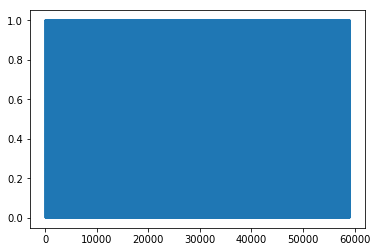

In [42]:
'''In this cell the visualizations for the random click model experiment are generated


#Beautiful

'''


plt.plot(range(len(P_win_proportions)), P_win_proportions)
plt.show()

### Step 6 - interleaving experiment



In [ ]:
# Estimate alpha_uq from relevance labels

# Katja Hofmann, Anne Schuth, Shimon Whiteson, and Maarten de Rijke. Reusing historical interaction
# data for faster online learning to rank for IR. In WSDM, 2013. ACM Press. 69, 70, 77

alpha = {
    'perfect' : {'N' : 0.0, 'R' : 0.5, 'HR' : 1.0},
    'navigational' : {'N' : 0.05, 'R' : 0.5, 'HR' : 0.95},
    'informal' : {'N' : 0.4, 'R' : 0.7 , 'HR' : 0.9}
}

# In this cell the random click model 
rho = MLE_random_click(search_sessions)
random_clicks = simulate_random_click_model(P[0], rho)
random_clicks